<img src="images/dask_logo.jpg">

# Dask Features

- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overheads

http://dask.pydata.org/en/latest/

In [1]:
import dask
import dask.multiprocessing

## Define two slow functions

In [2]:
from time import sleep

def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

In [3]:
%%time
x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)

CPU times: user 1.57 ms, sys: 250 µs, total: 1.82 ms
Wall time: 3.01 s


# Parallelize with dask.delayed

- Functions wrapped by `dask.delayed` don't run immediately, but instead put those functions and arguments into a task graph. 
- The result is computed separately by calling the `.compute()` method.

In [4]:
from dask import delayed

In [5]:
x = delayed(slowinc)(1)
y = delayed(slowinc)(2)
z = delayed(slowadd)(x, y)

In [6]:
%%time
z.compute()

CPU times: user 7.24 ms, sys: 5.54 ms, total: 12.8 ms
Wall time: 2.02 s


5

# Dask graph

- Contains description of the calculations necessary to produce the result. 
- The z object is a lazy Delayed object. This object holds everything we need to compute the final result. We can compute the result with .compute() as above or we can visualize the task graph for this value with .visualize().

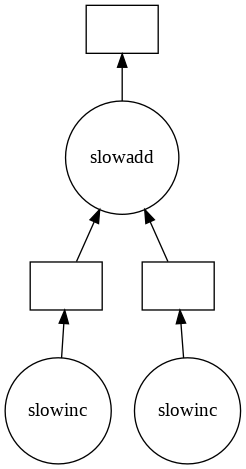

In [7]:
z.visualize()

# Parallelize a loop


In [8]:
%%time
data = list(range(8))

results = []

for x in data:
    y = slowinc(x)
    results.append(y)

total = sum(results)
total

CPU times: user 11.3 ms, sys: 3.1 ms, total: 14.4 ms
Wall time: 8.02 s


36

### Exercise 8.1

- Parallelize this by appending the delayed `slowinc` calls to the list `results`.
- Display the graph of `total` computation
- Compute time elapsed for the computation.

In [9]:
from dask import delayed

futures = []

for x in data:
    y = delayed(slowinc)(x)
    futures.append(y)

total = delayed(sum)(futures)

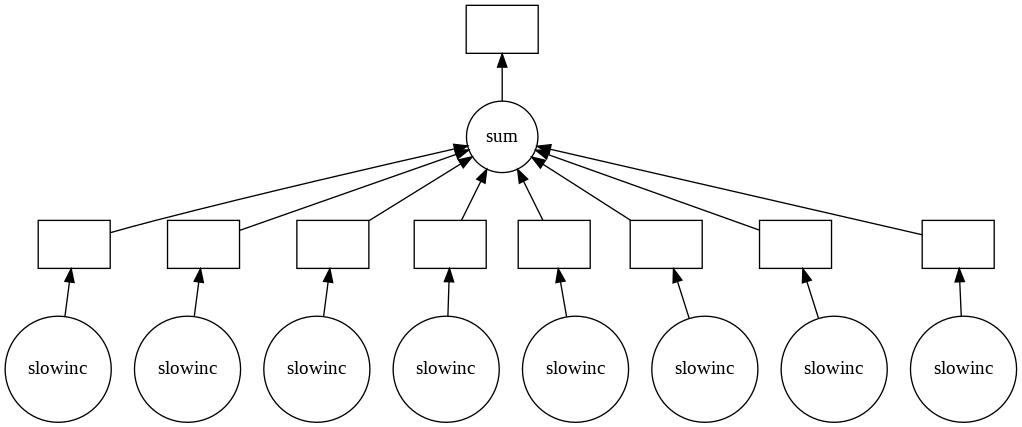

In [10]:
total.visualize()

In [11]:
%time total.compute()

CPU times: user 4.47 ms, sys: 9.07 ms, total: 13.5 ms
Wall time: 2.01 s


36

# Decorator

It is also common to see the delayed function used as a decorator. Same example:

In [12]:
%%time

@dask.delayed
def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

@dask.delayed
def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)
z.compute()

CPU times: user 4.77 ms, sys: 6.47 ms, total: 11.2 ms
Wall time: 2.01 s


5

# Control flow
-  Delay only some functions, running a few of them immediately. This is helpful when those functions are fast and help us to determine what other slower functions we should call. 
- In the example below we iterate through a list of inputs. If that input is even then we want to call `half`. If the input is odd then we want to call `odd_process`. This iseven decision to call `half` or `odd_process` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.


In [13]:
from random import randint
import dask.delayed

@dask.delayed
def half(x):
    sleep(1)
    return x // 2

@dask.delayed
def odd_process(x):
    sleep(1)
    return 3*x+1

def is_even(x):
    return not x % 2

data = [randint(0,100) for i in range(8)]
data

[65, 41, 61, 73, 11, 0, 41, 52]

### Exercise 8.2
- Parallelize the sequential code above using dask.delayed
- You will need to delay some functions, but not all
- Visualize and check the computed result


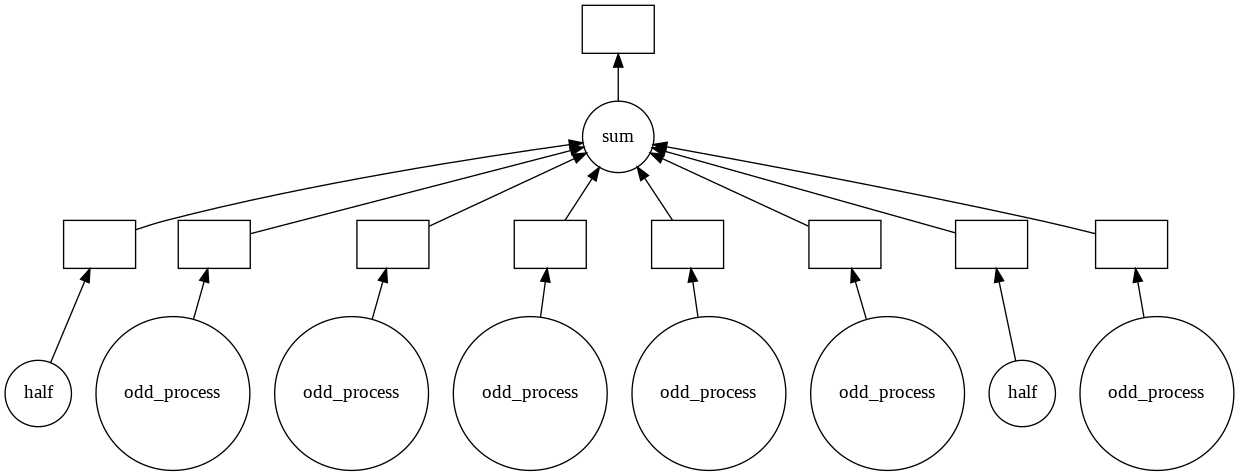

In [14]:
results = []
for x in data:
    if is_even(x):
        y = half(x)
    else:
        y = odd_process(x)
    results.append(y)
    
total = delayed(sum)(results)
total.visualize()

### Exercise 8.3
- Parallelize the hdf5 conversion from json files
- Create a function `convert_to_hdf`
- Use dask.compute function on delayed calls of the funtion created list
- Is it really  faster as expected ?

Hint: Read [Delayed Best Practices](http://dask.pydata.org/en/latest/delayed-best-practices.html)

In [15]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where,name)
    if not os.path.exists(datadir):
       print("Extracting data...")
       tar_path = os.path.join(where, name+'.tgz')
       with tarfile.open(tar_path, mode='r:gz') as data:
          data.extractall(where)
            
extract_data('daily-stock','../data') # this function call will extract json files

In [19]:
import os, sys
from glob import glob
import pandas as pd
import json

here = os.getcwd() # get the current directory
filenames = sorted(glob(os.path.join(here,'../data', 'daily-stock', '*.json')))

In [20]:
from tqdm.notebook import tqdm 

def read( fn ):
    with open(fn) as f:
        return [json.loads(line) for line in f]
    
def convert(data):
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, os.path.join(here,'..','data'))
    return

for fn in tqdm(filenames):  
    data = read( fn)
    convert(data)
    

In [21]:
%ls ../data/daily-stock/*.h5

../data/daily-stock/aet.h5   ../data/daily-stock/hpq.h5
../data/daily-stock/afl.h5   ../data/daily-stock/ibm.h5
../data/daily-stock/aig.h5   ../data/daily-stock/jbl.h5
../data/daily-stock/al.h5    ../data/daily-stock/jpm.h5
../data/daily-stock/amgn.h5  ../data/daily-stock/luv.h5
../data/daily-stock/avy.h5   ../data/daily-stock/met.h5
../data/daily-stock/b.h5     ../data/daily-stock/pcg.h5
../data/daily-stock/bwa.h5   ../data/daily-stock/tgt.h5
../data/daily-stock/ge.h5    ../data/daily-stock/usb.h5
../data/daily-stock/hal.h5   ../data/daily-stock/xom.h5
../data/daily-stock/hp.h5


In [22]:
@dask.delayed
def read( fn ):
    " read json file "
    with open(fn) as f:
        return [json.loads(line) for line in f]
    
@dask.delayed
def convert(data, fn):
    " convert json file to hdf5 file"
    df = pd.DataFrame(data)
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')
    return fn[:-5]

results = []
for filename in filenames:
    data = read(filename)
    results.append(convert(data, filename))

In [23]:
%time dask.compute(*results)

CPU times: user 11 s, sys: 1.34 s, total: 12.4 s
Wall time: 12.7 s


('/home/jovyan/notebooks/../data/daily-stock/aet',
 '/home/jovyan/notebooks/../data/daily-stock/afl',
 '/home/jovyan/notebooks/../data/daily-stock/aig',
 '/home/jovyan/notebooks/../data/daily-stock/al',
 '/home/jovyan/notebooks/../data/daily-stock/amgn',
 '/home/jovyan/notebooks/../data/daily-stock/avy',
 '/home/jovyan/notebooks/../data/daily-stock/b',
 '/home/jovyan/notebooks/../data/daily-stock/bwa',
 '/home/jovyan/notebooks/../data/daily-stock/ge',
 '/home/jovyan/notebooks/../data/daily-stock/hal',
 '/home/jovyan/notebooks/../data/daily-stock/hp',
 '/home/jovyan/notebooks/../data/daily-stock/hpq',
 '/home/jovyan/notebooks/../data/daily-stock/ibm',
 '/home/jovyan/notebooks/../data/daily-stock/jbl',
 '/home/jovyan/notebooks/../data/daily-stock/jpm',
 '/home/jovyan/notebooks/../data/daily-stock/luv',
 '/home/jovyan/notebooks/../data/daily-stock/met',
 '/home/jovyan/notebooks/../data/daily-stock/pcg',
 '/home/jovyan/notebooks/../data/daily-stock/tgt',
 '/home/jovyan/notebooks/../data/da